#### Testing out Gibbs zig-zag code:

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [2]:
d, Nobs = 10, 100
p = 1e-1
X = rand(Normal(), d, Nobs) .* rand(Binomial(1,p), d, Nobs)
X[1,:] = ones(Nobs)
ξ_true = rand(Normal(),d).* rand(Binomial(1,0.5), d)
ξ_true[1] = rand(Normal())
y = [rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] + 0. for j in 1:Nobs];
mb_size = 10
σ02 = 1

prior = HS_prior(d, σ02)

HS_prior(10, 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1.0)

In [3]:
my_ll = ll_logistic(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [4]:
# Sub-sampling with weights 
ϵ = 1e-2
weights = abs.(X) + ϵ
weights ./= sum(weights,2)
mb_size = 10;
gs = [wumbsampler(Nobs, mb_size, weights[i,:]) for i in 1:d]
gs_list = mbsampler_list(d,gs);

In [5]:
A = eye(d)
opf = projopf(A, 100, hyperparam_size(prior))
opt = maxa_opt(10^5)
outp = outputscheduler(opf,opt);

In [6]:
my_zz_sampler = zz_sampler(0, gs_list, linear_bound(my_model.ll, my_model.pr, gs_list))
hyper_sampler = block_gibbs_sampler(1.)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [7]:
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler});

alpha: 1.1857292124522467
alpha: 1.0382521057885583
alpha: 1.0233571584105563
alpha: 1.017039685842038
alpha: 1.03591284006029
alpha: 1.0632347676477678
alpha: 1.6482584523495685
alpha: 1.616715670775992
alpha: 1.058329828300437
alpha: 1.0575576316814295
alpha: 1.0372904473249802
alpha: 1.5942134158824692
alpha: 2.1653215854324097
alpha: 1.0007681516614224
alpha: 2.1712716737040076
alpha: 1.0053169547026946
alpha: 1.0457602456362134
alpha: 1.0296206056158426
alpha: 1.1847991604670018
alpha: 1.1193488431749807
alpha: 1.1730933678351552
alpha: 1.1110656078127936
alpha: 2.463250865445066
alpha: 1.4678061399113205
alpha: 1.0040386607667606
alpha: 1.350840764955634
alpha: 1.0976452059249655
alpha: 1.227174043355866
alpha: 1.0215690383406277
alpha: 1.138102180951615
alpha: 1.0277164360219708
alpha: 1.087299873024923
alpha: 1.9967751341967486
alpha: 1.0011380956000147
alpha: 1.017517539648829
alpha: 1.0361183588927318
alpha: 1.0396827617838718
alpha: 1.1451375102253396
alpha: 1.44051647173242

alpha: 1.262557904311392
alpha: 1.1530946071628585
alpha: 1.4974489617664148
alpha: 1.5389554228067734
alpha: 5.787475442900892
alpha: 1.2011672164665117
alpha: 1.183005499547412
alpha: 1.0690021048814695
alpha: 1.1529433871392454
alpha: 1.3442089273879576
alpha: 1.231875486668639
alpha: 1.942007137318405
alpha: 1.0090857284300627
alpha: 1.6285812590586959
alpha: 1.0388023129897412
alpha: 1.1333714245344224
alpha: 1.332033035112069
alpha: 1.8075895574128644
alpha: 1.0326911071002514
alpha: 2.1286240648889554
alpha: 1.1735782188122064
alpha: 1.1434312982405317
alpha: 1.263841651768538
alpha: 1.4995159021382303
alpha: 1.185796220602435
alpha: 1.0461866655698882
alpha: 1.0546834277520178
alpha: 1.8415118772740857
alpha: 1.333802571917202
alpha: 1.1605717950370886
alpha: 1.8523266645305227
alpha: 2.3846995367364388
alpha: 1.1931455215483124
alpha: 1.4085927453243687
alpha: 1.6122341223204941
alpha: 1.1994091479130558
alpha: 1.428754443084998
alpha: 1.050152104469611
alpha: 1.21582210357415

alpha: 1.0010482544487032
alpha: 1.4064003023813807
alpha: 1.0348016373632187
alpha: 1.3554896583091771
alpha: 1.0079002802514323
alpha: 4.218723902286402
alpha: 9.044996103459088
alpha: 2.18239596351286
alpha: 1.016912965581168
alpha: 1.7093877652149319
alpha: 3.634621084905938
alpha: 1.0489798212358925
alpha: 1.0085308807062272
alpha: 1.1278838476140365
alpha: 7.173120224744581
alpha: 1.1745970528348466
alpha: 1.2551139683315558
alpha: 2.477447161252665
alpha: 1.0264660208887457
alpha: 1.1989694359907341
alpha: 2.0151759170384103
alpha: 1.005326132631984
alpha: 3.1392549287473948
alpha: 32.77867055057859
alpha: 2.0386938976222932
alpha: 1.6241652065718044
alpha: 2.4944831049395244
alpha: 1.2471223580470465
alpha: 1.979932383008878
alpha: 2.154119717234589
alpha: 1.0080996576501944
alpha: 1.6189433296030138
alpha: 1.0286012934297444
alpha: 2.483157241231712
alpha: 1.2542859252412255
alpha: 1.6301076940196004
alpha: 1.0485721904223697
alpha: 1.0398352512805076
alpha: 1.5440923903150459

alpha: 1.0147855737773508
alpha: 1.0217883429181673
alpha: 1.042488130561171
alpha: 1.3452835880307736
alpha: 1.1605429626637993
alpha: 1.6838995679392017
alpha: 1.1407939781444663
alpha: 1.0096988901200796
alpha: 1.2788519623553205
alpha: 1.8076310176604116
alpha: 2.5483364033640847
alpha: 1.0028888566772138
alpha: 1.0598578383438781
alpha: 1.001391271831065
alpha: 2.87548029805525
alpha: 1.0049123531573498
alpha: 2.1236020719168383
alpha: 1.7896452018476396
alpha: 1.0460222857699795
alpha: 1.2179222221607593
alpha: 1.3400930120605465
alpha: 2.228308123813321
alpha: 1.0111583995388247
alpha: 2.656161885107613
alpha: 1.8752832746721033
alpha: 1.2258618905144976
alpha: 1.3084341154915453
alpha: 1.1262356662962365
alpha: 1.3767065495236468
alpha: 1.0201135592726405
alpha: 1.006773170248557
alpha: 1.3881964803840814
alpha: 1.4227636631071687
alpha: 3.901589737306206
alpha: 1.5325919723217498
alpha: 1.2557914867515414
alpha: 1.4199539940047214
alpha: 1.6163097982084431
alpha: 1.16289270197

alpha: 1.1633001223474573
alpha: 1.3502167183269298
alpha: 1.1774395180668045
alpha: 1.0092082481577123
alpha: 1.311070523359587
alpha: 1.0532094722053038
alpha: 1.1465566988309592
alpha: 1.0646957094051779
alpha: 1.067929891604412
alpha: 5.095185749724982
alpha: 1.0475413381337426
alpha: 1.4082899439776833
alpha: 1.0552843461601256
alpha: 1.168768849220372
alpha: 1.2670607221289116
alpha: 1.1118549105149946
alpha: 1.0033926847421124
alpha: 1.3349574013797707
alpha: 1.0395227769359918
alpha: 1.3282401431185196
alpha: 1.570660592859164
alpha: 1.5394834771802817
alpha: 1.2146814334191016
alpha: 1.0024543676074922
alpha: 2.000583406230686
alpha: 4.0701745199976145
alpha: 1.0029714082819656
alpha: 1.6835759237314118
alpha: 1.2067912648439574
alpha: 1.0381180315144134
alpha: 1.1775630962355441
alpha: 1.2672866964804876
alpha: 1.6004832371811082
alpha: 1.2308681767886307
alpha: 1.7040646452343626
alpha: 1.1582877033976366
alpha: 1.1042929593244941
alpha: 1.2707127587577847
alpha: 1.936845513

alpha: 1.018641338790137
alpha: 1.7104862634232874
alpha: 19.827441210016616
alpha: 1.058675398279959
alpha: 1.2087660506711484
alpha: 2.33725908712147
alpha: 2.8533774866760417
alpha: 1.6592650700923839
alpha: 6.5943255636861515
alpha: 4.456856409023417
alpha: 1.1374574371304642
alpha: 1.0494174074719513
alpha: 1.21645963828867
alpha: 1.6078513706532522
alpha: 7.9850638402743686
alpha: 1.1444888892824476
alpha: 1.0361776540246883
alpha: 3.675059380910591
alpha: 2.1347327950653683
alpha: 1.2247085147186727
alpha: 1.037072327263096
alpha: 1.8958164990062092
alpha: 1.0687619509169535
alpha: 1.237586266598067
alpha: 2.570661049213961
alpha: 1.0849858014141767
alpha: 1.050403623490243
alpha: 4.796748731723123
alpha: 1.3533855853202483
alpha: 1.2985389469642141
alpha: 1.6014790634678453
alpha: 16.34046820650161
alpha: 1.4723736878812674
alpha: 15.05869394591818
alpha: 2.072922690152995
alpha: 1.740409356852843
alpha: 1.0767210056606633
alpha: 1.678327202407935
alpha: 1.371014826117119
alpha

alpha: 1.4696727835126457
alpha: 20.151754060232367
alpha: 1.1177773910608715
alpha: 1.1419780019775554
alpha: 11.826224004374101
alpha: 2.162666203236069
alpha: 1.0552451925453872
alpha: 2.4940641103303998
alpha: 1.288950608730601
alpha: 9.742604849711636
alpha: 1.217636328301125
alpha: 64.02511665498817
alpha: 13.807354802316626
alpha: 19.519847594158314
alpha: 1.0015313531285597
alpha: 1.7570842951437673
alpha: 1.0198224260720465
alpha: 1.028183970097786
alpha: 1.0320773098675473
alpha: 66.59233103650861
alpha: 1.491764256163281
alpha: 1.6709469950273026
alpha: 4.529130304146483
alpha: 3.3414353532828156
alpha: 1.1251502457811302
alpha: 1.1884531965968226
alpha: 2.9599207552882887
alpha: 1.4845778046088265
alpha: 1.7229566590107843
alpha: 1.3974132237566625
alpha: 1.0876956766767754
alpha: 1.818926032335047
alpha: 1.0465274414284267
alpha: 1.025873829365477
alpha: 1.0112600526126696
alpha: 1.9377875544444034
alpha: 8.170037301585259
alpha: 1.098776087170578
alpha: 1.3226065504177755

alpha: 1.0901518450704917
alpha: 1.0626707186850268
alpha: 1.2518798946058272
alpha: 1.0464534895438966
alpha: 2.4392234228028666
alpha: 2.15820571749243
alpha: 1.0081377747074196
alpha: 1.2882497999961517
alpha: 1.1356933988305022
alpha: 1.1039766801401876
alpha: 1.1835325008899604
alpha: 1.2368455690928513
alpha: 1.0308437673634379
alpha: 1.5052120907090594
alpha: 4.018271336815398
alpha: 2.0186068317118764
alpha: 2.241580915371701
alpha: 1.2525073405598421
alpha: 1.0239836415584151
alpha: 1.4575501920674863
alpha: 1.3483440364521257
alpha: 1.9179296264518595
alpha: 1.2483514143013936
alpha: 1.4824680228272062
alpha: 2.5574446695628543
alpha: 1.626802636383942
alpha: 1.4186906041524745
alpha: 1.0078551410112684
alpha: 1.5129776651450608
alpha: 1.4121656380574283
alpha: 1.124626542507261
alpha: 1.1070788343443252
alpha: 5.35787425380074
alpha: 1.2296954346725053
alpha: 2.4825360909847523
alpha: 1.1148292559826263
alpha: 1.1268050143848396
alpha: 1.5654121928360638
alpha: 1.01837944784

alpha: 1.13675658368814
alpha: 1.9387126489693753
alpha: 1.4624961041252869
alpha: 1.010797680298925
alpha: 1.0522817274072185
alpha: 1.1750608335525645
alpha: 1.2143998633909614
alpha: 1.052986603901982
alpha: 1.0593290102628994
alpha: 1.3810942063217315
alpha: 1.0933814822857617
alpha: 1.054770345254683
alpha: 1.3327650766862276
alpha: 1.1585440201195563
alpha: 1.1932016565478611
alpha: 1.3393664104429832
alpha: 1.105964378237068
alpha: 1.0153367092983963
alpha: 1.2735499680733362
alpha: 1.1184817500589914
alpha: 1.055060645028389
alpha: 1.765866756226582
alpha: 1.2768121069618863
alpha: 1.226124654159742
alpha: 1.0821166805567504
alpha: 1.1162994517649312
alpha: 1.0380822787608963
alpha: 1.0292025825597524
alpha: 1.153672689699044
alpha: 1.0930621656537607
alpha: 1.3835006174104836
alpha: 1.3183086948866631
alpha: 1.258404496445484
alpha: 1.9311895347000954
alpha: 1.0961805003751197
alpha: 1.6312112360455777
alpha: 1.2171017204558314
alpha: 1.4927172452006559
alpha: 1.06788437380462

alpha: 1.0307106263798727
alpha: 1.0637307076287672
alpha: 1.0802430601744406
alpha: 1.307964690422905
alpha: 2.527875181943304
alpha: 1.1148828703694846
alpha: 1.1324590697066128
alpha: 1.107250161586381
alpha: 1.4641543601509839
alpha: 1.065881605590965
alpha: 1.1288602278859785
alpha: 1.0247165228118973
alpha: 1.0003370414874293
alpha: 1.4608088061416646
alpha: 1.0137324187187364
alpha: 4.055877364687596
alpha: 1.1325819828169739
alpha: 1.9976394723401134
alpha: 1.0024286742695199
alpha: 1.2073304830511316
alpha: 1.091037582130126
alpha: 1.0237013139832152
alpha: 1.00223232196114
alpha: 1.0885107281299962
alpha: 1.1841823265533606
alpha: 1.015084243769207
alpha: 1.3674304763153695
alpha: 1.074231935233268
alpha: 1.0261061211030722
alpha: 2.035011840374424
alpha: 1.3059485877333294
alpha: 1.019943214765418
alpha: 1.1622759889606336
alpha: 1.06191408464557
alpha: 2.419471830566446
alpha: 1.4607502635204876
alpha: 1.0223711391334789
alpha: 3.37502158814172
alpha: 1.0707064612846084
alp

In [6]:
GZZ_sample(my_model, outp, gs_list, samples, T_gibbs, n_gibbs);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


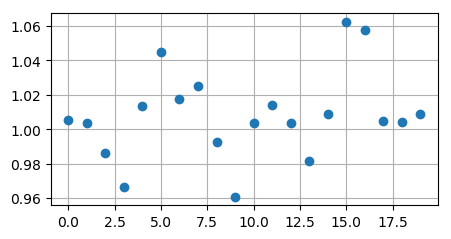

In [7]:
fig = figure("pyplot_barplot",figsize=(5,2.5))
plot([compute_configT(my_model, samples, k) for k in 1:d], "o")
grid(true)

In [10]:
rand(Exponential(10))

21.96079483762189

#### Posterior summaries:

In [28]:
print("posterior variances: ", [var(samples.xi_samples[i,:]) for i in 1:d], "\n")
print("posterior means    : ", [mean(samples.xi_samples[i,:]) for i in 1:d], "\n") 
print("true xi value      : ", ξ_true)

posterior variances: [0.31305, 2.97753, 1.41762, 1.07549, 0.987124, 1.68801, 2.42887, 3.80637, 3.11643, 1.52468, 4.82378, 0.727354, 2.07547, 2.03446, 9.50837, 1.15351, 1.02391, 1.11554, 1.08498, 0.997897, 5.51162, 1.90909, 2.15066, 4.98149, 0.6582, 5.57169, 3.21338, 1.71428, 3.21774, 2.14763, 1.35833, 1.90063, 1.8931, 1.0906, 1.58933, 3.2059, 2.74881, 1.04494, 1.43749, 2.65705, 1.81048, 3.30231, 1.94329, 11.5626, 4.16948, 1.29949, 2.27987, 6.32598, 4.06528, 1.5249]
posterior means    : [-2.23773, 3.04589, 1.69925, -0.469693, 0.393517, -0.999613, 2.79372, 3.96086, 1.88281, -0.183959, -2.64013, 0.621312, 0.335916, -0.525036, -5.73537, -1.46627, 1.39395, -0.262753, 0.408396, 0.0850821, 2.95556, 1.49889, 1.13366, -3.07182, -0.277696, 1.77458, 1.12842, 1.89927, 0.820322, -2.16899, 0.27105, 0.31527, -0.995848, 0.260624, 1.77017, 2.85273, 0.991793, 0.200771, 0.659838, -2.44036, 2.46329, 0.416757, -0.381733, 6.9001, 2.80433, 1.93425, 1.11208, 4.38547, -3.8717, -1.22312]
true xi value      : [-

In [ ]:
γ